In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [43]:
import os
from os.path import join

import numpy as np
import pandas as pd

!pip install tensorflow
import tensorflow as tf
import keras
from keras import layers, Input, models
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

# print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

In [6]:
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [7]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [8]:
df = df.drop(['waferIndex'], axis = 1)

In [9]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
639856,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot40335,[[Test]],[[none]],"(26, 26)"
390228,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4423.0,lot23427,[],[],"(74, 76)"
104515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1264.0,lot7146,[],[],"(41, 39)"
642095,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot40425,[[Test]],[[none]],"(26, 26)"
778190,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46192,[[Test]],[[none]],"(42, 44)"


In [10]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\array_algos\replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [11]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [12]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


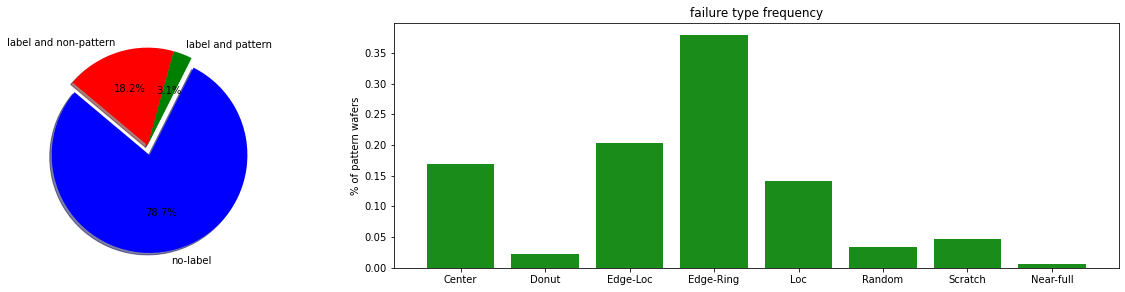

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [14]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [15]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [16]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


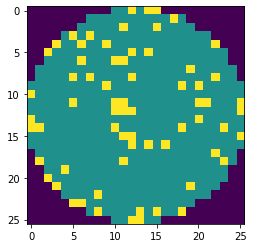

Faulty case : ['none'] 


In [17]:
# plot 1st data
plt.imshow(x[2040])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[2040]))

In [18]:
x = x.reshape((-1, 26, 26, 1))

In [19]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [20]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [21]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [22]:
new_x.shape

(14366, 26, 26, 3)

In [23]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [24]:
epoch=30
batch_size=1024

In [25]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 14s - loss: 0.1611 - 14s/epoch - 947ms/step
Epoch 2/30
15/15 - 14s - loss: 0.0982 - 14s/epoch - 906ms/step
Epoch 3/30
15/15 - 14s - loss: 0.0868 - 14s/epoch - 908ms/step
Epoch 4/30
15/15 - 14s - loss: 0.0756 - 14s/epoch - 922ms/step
Epoch 5/30
15/15 - 14s - loss: 0.0658 - 14s/epoch - 928ms/step
Epoch 6/30
15/15 - 14s - loss: 0.0579 - 14s/epoch - 935ms/step
Epoch 7/30
15/15 - 14s - loss: 0.0511 - 14s/epoch - 949ms/step
Epoch 8/30
15/15 - 14s - loss: 0.0451 - 14s/epoch - 958ms/step
Epoch 9/30
15/15 - 15s - loss: 0.0396 - 15s/epoch - 971ms/step
Epoch 10/30
15/15 - 15s - loss: 0.0346 - 15s/epoch - 973ms/step
Epoch 11/30
15/15 - 15s - loss: 0.0305 - 15s/epoch - 987ms/step
Epoch 12/30
15/15 - 15s - loss: 0.0271 - 15s/epoch - 997ms/step
Epoch 13/30
15/15 - 15s - loss: 0.0244 - 15s/epoch - 972ms/step
Epoch 14/30
15/15 - 14s - loss: 0.0222 - 14s/epoch - 910ms/step
Epoch 15/30
15/15 - 14s - loss: 0.0204 - 14s/epoch - 919ms/step
Epoch 16/30
15/15 - 14s - loss: 0.0188 - 14s/epoc

In [26]:
encoder = models.Model(input_tensor, latent_vector)

In [27]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [28]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [29]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

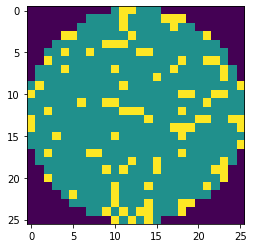

In [30]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

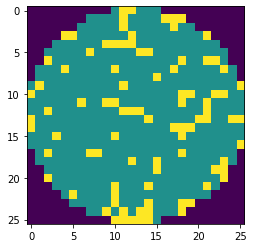

In [31]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [32]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [33]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [34]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [35]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [36]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [37]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [38]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [39]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [44]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [45]:
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [47]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)


In [48]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [49]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
9/9 - 27s - loss: 1.7039 - accuracy: 0.3948 - 27s/epoch - 3s/step
Epoch 2/30
9/9 - 30s - loss: 0.7066 - accuracy: 0.7477 - 30s/epoch - 3s/step
Epoch 3/30
9/9 - 30s - loss: 0.4398 - accuracy: 0.8576 - 30s/epoch - 3s/step
Epoch 4/30
9/9 - 31s - loss: 0.2578 - accuracy: 0.9096 - 31s/epoch - 3s/step
Epoch 5/30
9/9 - 32s - loss: 0.1330 - accuracy: 0.9624 - 32s/epoch - 4s/step
Epoch 6/30
9/9 - 33s - loss: 0.0618 - accuracy: 0.9853 - 33s/epoch - 4s/step
Epoch 7/30
9/9 - 34s - loss: 0.0418 - accuracy: 0.9896 - 34s/epoch - 4s/step
Epoch 8/30
9/9 - 36s - loss: 0.0282 - accuracy: 0.9935 - 36s/epoch - 4s/step
Epoch 9/30
9/9 - 38s - loss: 0.0171 - accuracy: 0.9971 - 38s/epoch - 4s/step
Epoch 10/30
9/9 - 41s - loss: 0.0110 - accuracy: 0.9981 - 41s/epoch - 5s/step
Epoch 11/30
9/9 - 44s - loss: 0.0074 - accuracy: 0.9989 - 44s/epoch - 5s/step
Epoch 12/30
9/9 - 48s - loss: 0.0066 - accuracy: 0.9985 - 48s/epoch - 5s/step
Epoch 13/30
9/9 - 52s - loss: 0.0061 - accuracy: 0.9980 - 52s/epoch - 6s/

In [50]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/30
13/13 - 72s - loss: 1.5349 - accuracy: 0.4471 - val_loss: 0.8051 - val_accuracy: 0.7144 - 72s/epoch - 6s/step
Epoch 2/30
13/13 - 72s - loss: 0.5200 - accuracy: 0.8332 - val_loss: 0.3384 - val_accuracy: 0.8796 - 72s/epoch - 6s/step
Epoch 3/30
13/13 - 72s - loss: 0.1874 - accuracy: 0.9408 - val_loss: 0.1536 - val_accuracy: 0.9531 - 72s/epoch - 6s/step
Epoch 4/30
13/13 - 72s - loss: 0.0685 - accuracy: 0.9833 - val_loss: 0.0524 - val_accuracy: 0.9876 - 72s/epoch - 6s/step
Epoch 5/30
13/13 - 72s - loss: 0.0238 - accuracy: 0.9962 - val_loss: 0.0406 - val_accuracy: 0.9909 - 72s/epoch - 6s/step
Epoch 6/30
13/13 - 72s - loss: 0.0176 - accuracy: 0.9970 - val_loss: 0.0434 - val_accuracy: 0.9892 - 72s/epoch - 6s/step
Epoch 7/30
13/13 - 73s - loss: 0.0117 - accuracy: 0.9978 - val_loss: 0.0244 - val_accuracy: 0.9939 - 73s/epoch - 6s/step
Epoch 8/30
13/13 - 73s - loss: 0.0111 - accuracy: 0.9980 - val_loss: 0.0430 - val_accuracy: 0.9900 - 73s/epoch - 6s/step
Epoch 9/30
13/13 - 73s - loss: 0

In [51]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

7/7 - 10s - loss: 0.0198 - accuracy: 0.9952 - 10s/epoch - 1s/step
Testing Accuracy: 0.9952152967453003


In [59]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


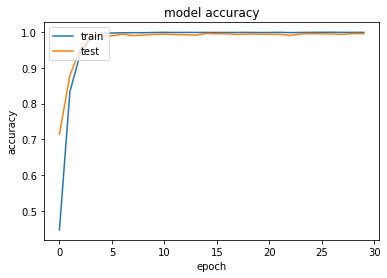

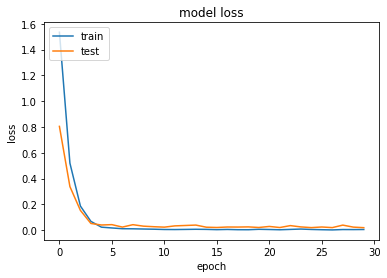

In [60]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()